In [549]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
from sklearn import svm
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
)

In [550]:
sex= 'Male'
control = pd.read_csv(f"../result/Control_{sex}_snp.csv")
training = pd.read_csv(f"../result/Training_{sex}_snp.csv")

print(control.shape)
print(training.shape)

(885, 205)
(465, 205)


In [551]:
features = pd.concat([control,training],ignore_index=True)
features = features.drop(columns=['TWB2_ID','I_32','Label'])

#將ID排除
X = features.iloc[:,1::]
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=pd.concat([control_label,training_label],ignore_index=True)
label_encoder = LabelEncoder()
y = list(label_encoder.fit_transform(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Columns: 201 entries, AGE to MICROALB
dtypes: float64(154), int64(47)
memory usage: 2.1 MB
None
樣本數:  1350


In [552]:
from collections import Counter

# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 1215
測試集樣本數量： 135
訓練集中各類別樣本數量：
Counter({0: 792, 1: 423})
測試集中各類別樣本數量：
Counter({0: 93, 1: 42})


In [553]:
# SMOTE
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("SMOTE train set sampling:")
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(
    random_state=42, kind="borderline-2"
).fit_resample(X_train, y_train)
print("BSMOTE train set sampling:")
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val, y_val)
print("Random sampling:")
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val, y_val)
print("SMOTE test set sampling:")
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val, y_val)
print("BSMOTE test set sampling:")
print(Counter(bsmote_test_Y))

SMOTE train set sampling:
Counter({0: 792, 1: 792})
BSMOTE train set sampling:
Counter({0: 792, 1: 792})
Random sampling:
Counter({0: 42, 1: 42})
SMOTE test set sampling:
Counter({0: 93, 1: 93})
BSMOTE test set sampling:
Counter({0: 93, 1: 93})


In [554]:
# Male
selected_features = ['I_18', 'I_11', 'I_23', 'ANTI_HBC_AB_1', 'EYE_DIS', 'NECK_ACHE',
                     'BACK_AND_WAIST_ACHE', 'CARCINOMA_IN_SITU', 'DIABETES', 'GOUT']
selected_rs = features.iloc[:,113:113+47].columns.tolist()
# Female
# selected_features = ['I_16', 'I_22', 'I_11', 'ORTHOPEDICS_ARTICULUS', 'EYE_DIS', 'I_18',
#                     'ARTICULUS_ACHE', 'MENSTRURATION_CURR', 'I_33', 'I_24', 'SPO_HABIT',
#                     'DIABETES', 'I_35', 'I_26', 'MC_DURATION', 'I_37', 'I_9', 'AGE', 'I_31',
#                     'CARCINOMA_IN_SITU']
# selected_rs = features.iloc[:,121:121+47].columns.tolist()
print(selected_rs)
selected_features = selected_features + selected_rs
indices = [feature_names.get_loc(feature) for feature in selected_features]
print("feature num:", len(indices))

smote_train_X = [[row[i] for i in indices] for row in smote_train_X]
smote_test_X = [[row[i] for i in indices] for row in smote_test_X]
bsmote_test_X = [[row[i] for i in indices] for row in bsmote_test_X]

['rs74315294', 'rs80356605', 'rs199766465', 'rs397515598', 'rs752043324', 'rs1805124', 'rs751538672', 'rs11934801', 'rs369107336', 'rs192654796', 'rs969485098', 'rs144286892', 'rs775633137', 'rs121912910', 'rs111033313', 'rs121908362', 'rs41307295', 'rs199472941', 'rs1060500661', 'rs193066451', 'rs515726199', 'rs515726186', 'rs745750156', 'rs776825296', 'rs2228527', 'rs747453876', 'rs199473471', 'rs62645916', 'rs146689036', 'rs34946266', 'rs773528125', 'rs111033204', 'rs80338943', 'rs28942074', 'rs755377592', 'rs312262709', 'rs146682486', 'rs2020959', 'rs63750402', 'rs747175448', 'rs766187994', 'rs1267868260', 'rs724159978', 'rs1140458', 'rs75949023', 'rs121909104', 'rs201118034']
feature num: 57


In [555]:
def plot_confusion_matrix(confusion):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True])
    cm_display.plot()
    plt.show()

def evalution_metrics(test_label, labels_score, txt_name, save=True, path="../result/"):
    accuracy = accuracy_score(test_label, labels_score.round())
    confusion = confusion_matrix(test_label, labels_score.round())

    # plot confusion matrix
    plot_confusion_matrix(confusion)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    precision = TP / float(TP + FP)
    sensitivity = TP / float(FN + TP)
    specificity = TN / float(TN + FP)
    f1 = f1_score(test_label, labels_score.round())
    mcc = matthews_corrcoef(test_label, labels_score.round())

    metrics = np.round([TP, TN, FP, FN, accuracy, precision, sensitivity, specificity, f1, mcc], 2)
    columns = ["TP","TN","FP","FN","accuracy","precision","sensitivity","specificity","f1","mcc",]
    metrics_dict = dict(zip(columns, metrics))

    if save:
        df = pd.DataFrame(metrics_dict, index=[0])
        df.to_csv(path + "%s_metrics.csv" % txt_name)

        print("  # TP: %f" % TP + "\n")
        print("  # TN: %f" % TN + "\n")
        print("  # FP: %f" % FP + "\n")
        print("  # FN: %f" % FN + "\n")
        print("  # Accuracy: %f" % accuracy + "\n")
        print("  # Precision: %f" % precision + "\n")
        print("  # Sensitivity/Recall: %f" % sensitivity + "\n")
        print("  # Specificity: %f" % specificity + "\n")
        print("  # F1 score: %f" % f1 + "\n")
        print("  # Matthews Corrcoef:%f" % mcc + "\n")
    else:
        return metrics_dict

In [556]:
X_train = np.array(smote_train_X)
y_train = np.array(smote_train_Y)

print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)

print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)

X_val = np.array(bsmote_test_X)
y_val = np.array(bsmote_test_Y)

X_train type: <class 'numpy.ndarray'>
X_train shape: (1584, 57)
y_train type: <class 'numpy.ndarray'>
y_train shape: (1584,)


#### CNN

In [557]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dense, Dropout, Add
#from tensorflow.keras.layers import Embedding, Masking
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

cnn_model = Sequential()
cnn_model.add(Input(shape=(X_train.shape[1], 1)))
# cnn_model.add(Conv1D(32, 10, activation='relu', padding="same",kernel_regularizer=regularizers.l2(0.0001))) # Female
cnn_model.add(Conv1D(64, 10, activation='relu', padding="same",kernel_regularizer=regularizers.l2(0.00001))) # Male
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.3)) # Female
cnn_model.add(Dropout(0.4)) # Male
cnn_model.add(Flatten())

cnn_model.add(Dense(1, activation = "sigmoid"))
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])

#saveBestModel = tensorflow.keras.callbacks.ModelCheckpoint(filepath=best_model, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#CSVLogger = tensorflow.keras.callbacks.CSVLogger("cnn_csvLogger.csv" ,separator=',', append=False)
#e_s = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=150,verbose=0, mode='min')

# Male epochs=800, batch_size=1024
# Female epochs=900, batch_size=1024
cnn_t_m = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=800, batch_size=1024)

Epoch 1/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.5041 - loss: 0.9273 - val_accuracy: 0.5699 - val_loss: 0.6653
Epoch 2/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5450 - loss: 0.7908 - val_accuracy: 0.6398 - val_loss: 0.6616
Epoch 3/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5502 - loss: 0.8051 - val_accuracy: 0.6237 - val_loss: 0.7198
Epoch 4/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5896 - loss: 0.7773 - val_accuracy: 0.6237 - val_loss: 0.6964
Epoch 5/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6143 - loss: 0.7396 - val_accuracy: 0.7097 - val_loss: 0.6671
Epoch 6/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6095 - loss: 0.7386 - val_accuracy: 0.7043 - val_loss: 0.6676
Epoch 7/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6115 - loss: 0.7387 - val_accuracy: 0.6828 - val_loss: 0.6653
Epoch 8/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6135 - loss: 0.7472 - val_accuracy: 0.6774 - val_loss

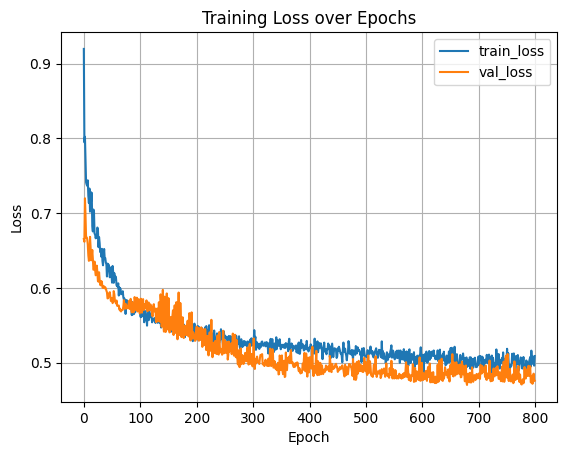

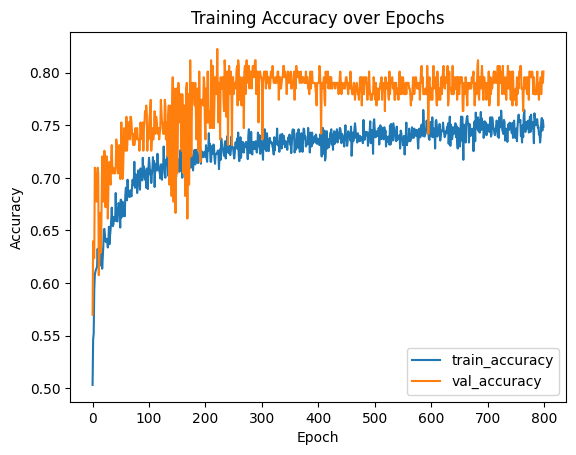

In [558]:
plt.plot(cnn_t_m.history["loss"], label="train_loss")
plt.plot(cnn_t_m.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(cnn_t_m.history["accuracy"], label="train_accuracy")
plt.plot(cnn_t_m.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend(loc="lower right")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


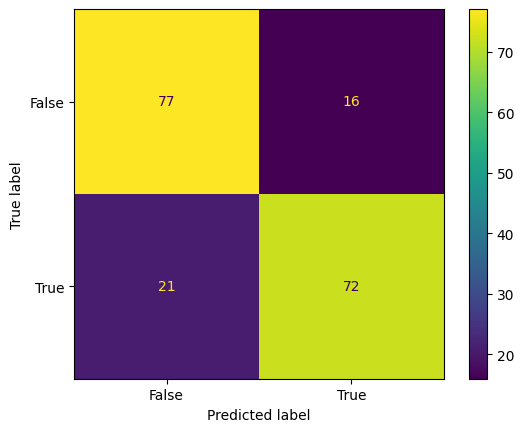

  # TP: 72.000000

  # TN: 77.000000

  # FP: 16.000000

  # FN: 21.000000

  # Accuracy: 0.801075

  # Precision: 0.818182

  # Sensitivity/Recall: 0.774194

  # Specificity: 0.827957

  # F1 score: 0.795580

  # Matthews Corrcoef:0.603023



In [559]:
# CNN prediction
cnn_score = cnn_model.predict(X_val)
cnn_res = evalution_metrics(y_val, cnn_score,'cnn')

#### LSTM

In [563]:
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=10, return_sequences=True))
lstm_model.add(Dropout(0.4)) # Male dropout=0.4、Female dropout=0.3
# lstm_model.add(LSTM(units = 10))
# lstm_model.add(Dropout(0.1))
lstm_model.add(Flatten())

# lstm_model.add(BatchNormalization())
lstm_model.add(Dense(units = 1, kernel_regularizer=l2(0.000001))) #Male l2: 1e-6, Female l2: 1e-4
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])

# Male epochs=2000, batch_size=512
# Female epochs=800, batch_size=256
lstm_t_m = lstm_model.fit(X_train, y_train, epochs = 2000, batch_size = 512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.4930 - loss: 0.5938 - val_accuracy: 0.5108 - val_loss: 0.2638
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5046 - loss: 0.3829 - val_accuracy: 0.5108 - val_loss: 0.3117
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5024 - loss: 0.3812 - val_accuracy: 0.5323 - val_loss: 0.2641
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5294 - loss: 0.3292 - val_accuracy: 0.5376 - val_loss: 0.2505
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4885 - loss: 0.3573 - val_accuracy: 0.5323 - val_loss: 0.2520
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5113 - loss: 0.3330 - val_accuracy: 0.5645 - val_loss: 0.2405
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5087 - loss: 0.3372 - val_accuracy: 0.6129 - val_loss: 0.2357
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5005 - loss: 0.3307 - val_accuracy: 0.6237 - v

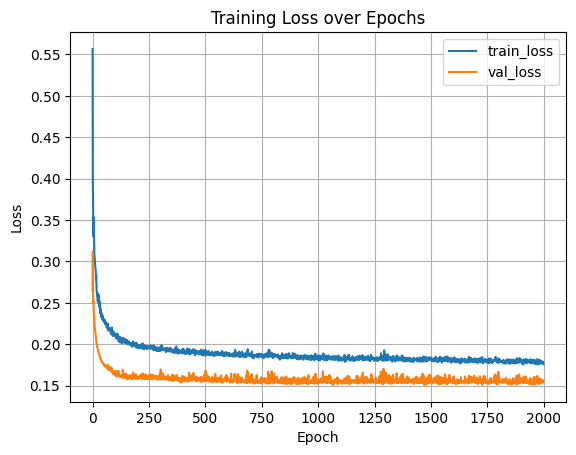

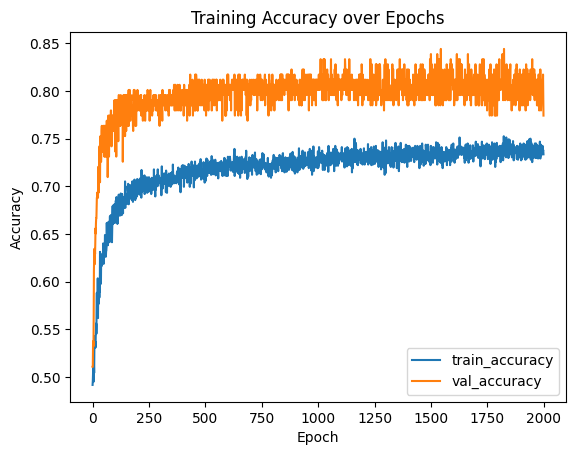

In [564]:
plt.plot(lstm_t_m.history["loss"], label="train_loss")
plt.plot(lstm_t_m.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(lstm_t_m.history["accuracy"], label="train_accuracy")
plt.plot(lstm_t_m.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend(loc="lower right")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


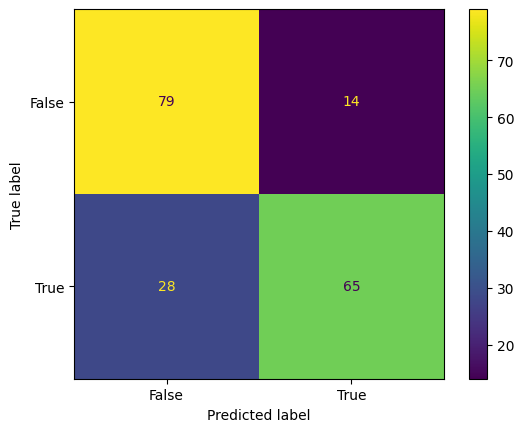

  # TP: 65.000000

  # TN: 79.000000

  # FP: 14.000000

  # FN: 28.000000

  # Accuracy: 0.774194

  # Precision: 0.822785

  # Sensitivity/Recall: 0.698925

  # Specificity: 0.849462

  # F1 score: 0.755814

  # Matthews Corrcoef:0.554708



In [565]:
# LSTM prediction
lstm_score = lstm_model.predict(X_val)
lstm_res = evalution_metrics(y_val, lstm_score,'lstm')